### Tensorflow example for MNIST
The goal of this demo is to correctly classify the handwritten digits 0-9.

This notebook predicts a single custom created digit

In [2]:
%matplotlib inline

import cPickle as pickle
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import cv2
import json
from scipy import ndimage

#### Hyperparameter

In [3]:
dictionary_processing_files = "pro-img/"
copy_image_file = "final_result.jpeg"
green_rectangle_positions = "rectangle_shapes.json"
final_result = "final_digitized_image.jpg"
basket = "/mnt/basket/processingData/volatile/"
pickle_training_results_filename = "RecognizeDigits_separeated__training_results.pickle"

First reload the data we generated in `02_training.ipynb`.

In [4]:
pickle_file = os.path.join(basket,pickle_training_results_filename)

with open(pickle_file, 'rb') as f:
  read = pickle.load(f)
  train_weights_linear = read['weights_linear']
  train_biases_linear = read['biases_linear']
  del read  # hint to help gc free up memory

#### Further adjust cropped image to the MNIST requirements

To calculate predictions it is needed to flatten the cropped images. <br>
Additional the MNIST images are in the range from 0-1 and not from 0-255 <br>
Therefore: 
 * reshape the cropped image data to a one dimensional vector with 784 pixels (28 row x 28 column = 784)
 * divide each pixel by max RGB value (255.0), to flatten the pixels to values between 0-1

In [5]:
def flatten_images(gray_shifted):
    gray_flatten = gray_shifted.flatten() / 255.0
    return gray_flatten

In [6]:
# get cropped image filenames by scaning the directory where we did store them
image_fileNames=[]
for filenames in os.listdir(dictionary_processing_files):
    if (filenames.endswith(".png")):
        image_fileNames.append(filenames)

# create an array where we can store the digits found in step "01_NormalizeImage.ipynb"
images = np.zeros((len(image_fileNames),784))

# flatten the images and store them in an array
i=0
for input_file in image_fileNames:
    gray = cv2.imread(dictionary_processing_files+input_file, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    flatten = flatten_images(gray)
    images[i] = flatten
    i = i + 1

## Define the graph

In [7]:
## A placeholder for our image data: None stands for an unspecified number of images 784 = 28*28 pixel
x = tf.placeholder("float", [None, 784])

# variables to tune
weights_linear = tf.constant(train_weights_linear)
biases_linear = tf.constant(train_biases_linear)

# linear function
test_logits = tf.matmul(x, weights_linear) + biases_linear

# Softmax
test_prediction = tf.nn.softmax(test_logits)

## Digression: Predict the fourth cropped image
The fourth cropped image represents digit "5"

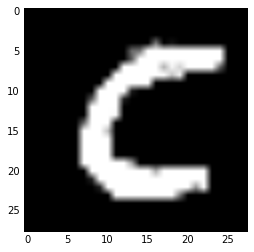

In [8]:
cropped_image_to_predict = 4
image_data = (ndimage.imread(dictionary_processing_files + image_fileNames[cropped_image_to_predict]))
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {4.0,6.0}
plt.imshow(image_data, cmap="gray")
plt.show()

Launch the graph in a session and initialize variables

In [9]:
sess = tf.Session()
tf.initialize_all_variables().run(session=sess)

calculate the reliability that the digit from this image belongs to  0,1,2,3,4,5,6,7,8,9

In [9]:
i = 0
prediction = test_prediction
predicted_results = sess.run(prediction, feed_dict={x: images})
for reliability in predicted_results[cropped_image_to_predict].tolist():
    print i , " : (" , np.round(reliability,4) , ")" 
    i = i + 1

0  : ( 0.0007 )
1  : ( 0.0 )
2  : ( 0.0009 )
3  : ( 0.0007 )
4  : ( 0.0005 )
5  : ( 0.9899 )
6  : ( 0.0 )
7  : ( 0.0001 )
8  : ( 0.0042 )
9  : ( 0.003 )


the sum of the reliability must always be "1.0" to represent "100 %"

In [10]:
print np.sum(predicted_results[cropped_image_to_predict]) , "    or    "  , \
    np.round(np.sum(predicted_results[cropped_image_to_predict]) * 100.0, 4) , "% "

1.0     or     100.0 % 


find the reliability with the highest value out of digit range [ 0,1,2,3,4,5,6,7,8,9 ]

In [11]:
reliability_max = tf.reduce_max(test_prediction,reduction_indices=1)
predicted_reliability = sess.run(reliability_max, feed_dict={x: images})
print predicted_reliability[cropped_image_to_predict]

0.989869


show the digit as a number refered to by the reliability_max

In [12]:
prediction = tf.argmax(test_prediction,1)
predicted_results = sess.run(prediction, feed_dict={x: images})
print predicted_results[cropped_image_to_predict]

5


close the session

In [13]:
sess.close()

## Predict all the digits in the original image


Launch the graph in a session and initialize variables


In [14]:
sess = tf.Session()
tf.initialize_all_variables().run(session=sess)

The prediction will contain the digit as a number in [1] and the reliability for this number in [0]

In [15]:
prediction = [tf.reduce_max(test_prediction,reduction_indices=1),tf.argmax(test_prediction,1)]
predicted_results = sess.run(prediction, feed_dict={x: images})

for i in range(len(predicted_results[0])):
    print "predicted digit:  %2d   | reliability_max: %4f   |   %s"  % \
       (predicted_results[1][i] , predicted_results[0][i] , image_fileNames[i])


predicted digit:   1   | reliability_max: 0.991794   |   cropped_diget_275_1300.png
predicted digit:   5   | reliability_max: 0.548117   |   cropped_diget_1400_600.png
predicted digit:   8   | reliability_max: 0.967656   |   cropped_diget_250_500.png
predicted digit:   3   | reliability_max: 0.967335   |   cropped_diget_1305_1265.png
predicted digit:   5   | reliability_max: 0.989869   |   cropped_diget_250_1755.png
predicted digit:   9   | reliability_max: 0.925066   |   cropped_diget_1375_960.png
predicted digit:   6   | reliability_max: 0.888914   |   cropped_diget_1320_1650.png
predicted digit:   4   | reliability_max: 0.583896   |   cropped_diget_700_950.png
predicted digit:   2   | reliability_max: 0.514165   |   cropped_diget_715_2145.png
predicted digit:   8   | reliability_max: 0.706240   |   cropped_diget_720_585.png
predicted digit:   7   | reliability_max: 0.692464   |   cropped_diget_320_550.png
predicted digit:   2   | reliability_max: 0.996514   |   cropped_diget_720_132

close the session

In [16]:
sess.close()

## Postprocessing
Draw a green rectangle around each digit in the original image which contains at its edges the predicted number 
of the digit and the maximum reliability for this prediction

##### Postprocessing: link predictions to saved png files

In [17]:
combined_images_with_predicted_results = dict()
i = 0
for file in image_fileNames:
    combined_images_with_predicted_results[dictionary_processing_files + file] = [predicted_results[0][i],predicted_results[1][i]]
    #combined_images_with_predicted_results.append([image_fileNames[i],predicted_results[i]])
    i = i +1
#print combined_images_with_predicted_results[dictionary_processing_files + 'cropped_diget_700_950.png'][1]

#### Postprocessing : Draw green rectangle

Read rectangle shapes from 01_NormalizeImage

In [18]:
with open(dictionary_processing_files + green_rectangle_positions) as data_file:    
    green_rectange_data = json.load(data_file)

Load the copy of the original image where the rectangles will be draw

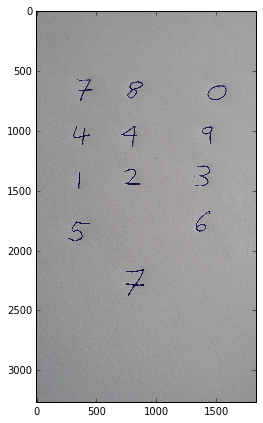

In [19]:
image_data = (ndimage.imread(dictionary_processing_files + copy_image_file))
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {7.0,10.0}
plt.imshow(image_data, cmap=None)
plt.show()

In [20]:
   
# delete this line !!
image_data = (ndimage.imread(dictionary_processing_files + copy_image_file))

#draw green rectangle (top_left_0 , filename , bottom_right_1 , bottom_right_0 , top_left_1)
for json_dictonary in green_rectange_data:
    filename = json_dictonary['filename']
    top_left_0 = json_dictonary['top_left_0']
    top_left_1 = json_dictonary['top_left_1']
    bottom_right_0 = json_dictonary['bottom_right_0']
    bottom_right_1 = json_dictonary['bottom_right_1']
    prediction_diget_top_1 = combined_images_with_predicted_results[filename][1]
    prediction_diget_top_1_reliability = combined_images_with_predicted_results[filename][0]
    
    cv2.rectangle(image_data,tuple((top_left_1, top_left_0)),tuple((bottom_right_1,bottom_right_0)),color=(0,255,0),thickness=5)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image_data,str(prediction_diget_top_1),(top_left_1,bottom_right_0 + 50),
               font,fontScale=1.4,color=(0,255,0),thickness=4)
    cv2.putText(image_data,format(prediction_diget_top_1_reliability*100,".1f")+"%",(top_left_1 + 70,bottom_right_0 + 50),
                font,fontScale=0.8,color=(0,255,0),thickness=2)
    
cv2.imwrite(dictionary_processing_files+final_result, image_data)

True

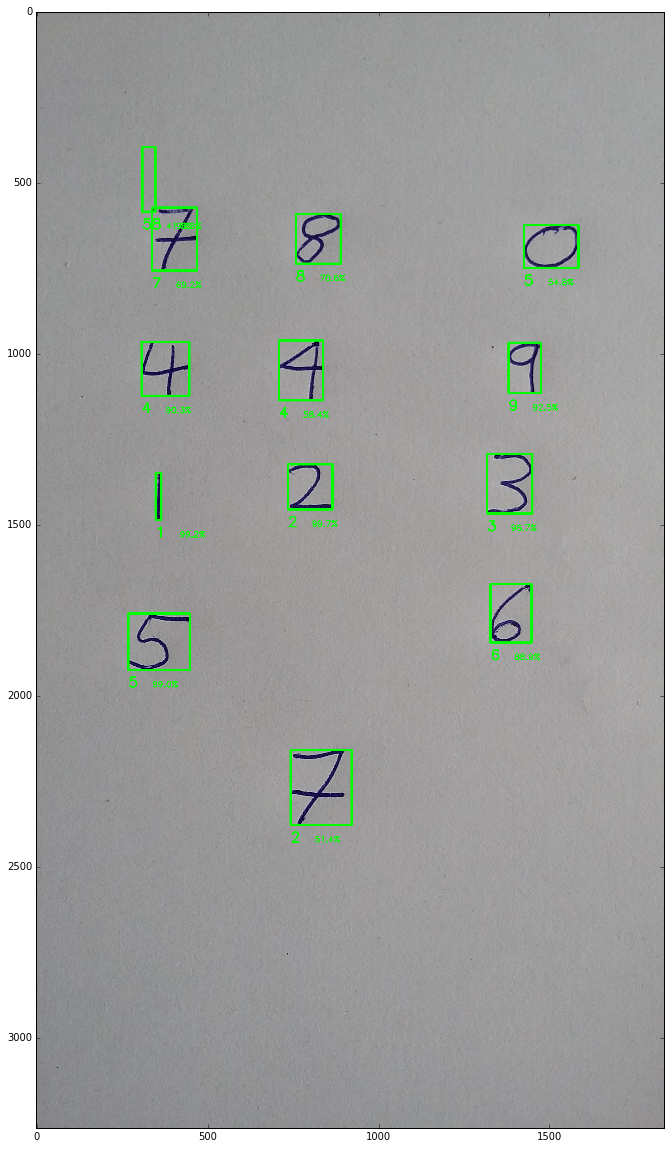

In [21]:
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {20.0,24.0}
plt.imshow(image_data, cmap=None)
plt.show()

#### Side note
The MNISt training data is based on handwritten digits in american style, 
which implies the German 7 and the American 7 are different in writting.
That explains the poor perfromance to predict the German 7 <br> <br>
I am not sure at the Moment why the 0 is predicted wrong, need to look into that one day :) <br>